### Wczytanie modelu YOLO

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 905.3/905.3 kB 21.8 MB/s eta 0:00:00


In [2]:
from ultralytics import YOLO
import cv2 as cv
import numpy as np

model_yolo = YOLO("yolo11n") # Używamy modelu trenowanego na zestawie COCO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.35M/5.35M [00:00<00:00, 80.8MB/s]


### Predykcja na przykładowym zdjęciu

In [3]:
import matplotlib.pyplot as plt

def show_results(results):
    # Visualize the results
    for i, r in enumerate(results):
        image = cv.cvtColor(r.plot(), cv.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.axis('off')
        plt.show()

In [ ]:
for image_url in (
    "https://ultralytics.com/images/zidane.jpg",
    "https://ultralytics.com/images/bus.jpg",
):
    results = model_yolo.predict(image_url)
    show_results(results)


### Zestaw treningowy

In [4]:
!unzip Dataset.zip

Archive:  Dataset.zip
   creating: Dataset/
  inflating: Dataset/data.yaml       
   creating: Dataset/test/
 extracting: Dataset/test/0.jpg      
  inflating: Dataset/test/0.txt      
  inflating: Dataset/test/1.jpg      
  inflating: Dataset/test/1.txt      
  inflating: Dataset/test/10.jpg     
  inflating: Dataset/test/10.txt     
 extracting: Dataset/test/11.jpg     
  inflating: Dataset/test/11.txt     
  inflating: Dataset/test/12.jpg     
  inflating: Dataset/test/12.txt     
 extracting: Dataset/test/13.jpg     
  inflating: Dataset/test/13.txt     
  inflating: Dataset/test/14.jpg     
  inflating: Dataset/test/14.txt     
  inflating: Dataset/test/15.jpg     
  inflating: Dataset/test/15.txt     
 extracting: Dataset/test/16.jpg     
  inflating: Dataset/test/16.txt     
  inflating: Dataset/test/17.jpg     
  inflating: Dataset/test/17.txt     
  inflating: Dataset/test/18.jpg     
  inflating: Dataset/test/18.txt     
  inflating: Dataset/test/19.jpg     
  inflating: Data

In [5]:
import os

PATH_TO_DATASET_CONFIG = os.path.abspath("Dataset/data.yaml")

import yaml

with open(PATH_TO_DATASET_CONFIG, "r") as file:
    data = yaml.safe_load(file)

data['path'] = os.path.dirname(PATH_TO_DATASET_CONFIG)

with open(PATH_TO_DATASET_CONFIG, "w") as file:
    yaml.dump(data, file)

print(f"Zawartość pliku \'{PATH_TO_DATASET_CONFIG}\':")
for key, value in data.items():
    print(f"{key}: {value}")

Zawartość pliku '/content/Dataset/data.yaml':
names: ['nakretka', 'sruba']
path: /content/Dataset
test: test
train: train
val: val


In [6]:
import glob

print("Zawartość zbioru danych:")
for subset in ("train", "val", "test"):
    labels = glob.glob(f"{data['path']}/{subset}/*.txt")
    print(f"\t{subset}: {len(labels)} etykiet(y)")

Zawartość zbioru danych:
	train: 120 etykiet(y)
	val: 40 etykiet(y)
	test: 40 etykiet(y)


/content/Dataset/train/61.txt
['0', '0.45703', '0.24902', '0.18359', '0.17188']
['1', '0.16992', '0.51660', '0.16016', '0.16016']
['1', '0.86133', '0.08105', '0.17676', '0.16211']
['1', '0.50684', '0.78223', '0.36914', '0.17188']


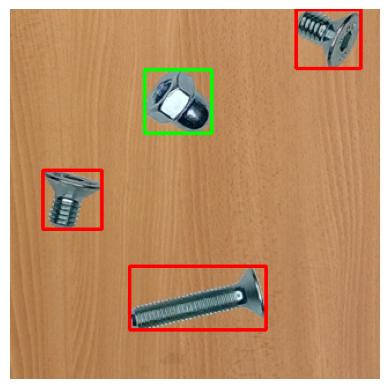

In [7]:
import random

SUBSET = 'train'

labels = glob.glob(f"{data['path']}/{SUBSET}/*.txt")

random_label = random.choice(labels)
random_image = random_label.replace(".txt", ".jpg")

print(random_label)

with open(random_label, "r") as file:
    labels = file.readlines()

image = cv.imread(random_image)

for label in labels:
    label = label.strip().split()
    print(label)
    x, y, w, h = [float(x) for x in label[1:]]
    classname = int(label[0])
    x1, y1 = int((x - w / 2) * image.shape[1]), int((y - h / 2) * image.shape[0])
    w, h = int(w * image.shape[1]), int(h * image.shape[0])

    cv.rectangle(image, (x1, y1), (x1 + w, y1 + h), (0, 255, 0) if classname==0 else (0,0,255), 2)

image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')
plt.show()


### Hiper parametry treningu

In [34]:
hiperparametry = {
    "imgsz": 320, # image size (int)
    "epochs": 30, # number of epochs (int)
    "batch": 10, # batch size (int)
    # LOSS GAIN --------------------------------------------------------------- #
    "box":  7.5, # box loss gain
    "cls":   0.50, # cls loss gain
    "dfl":  1.50, # dfl loss gain
    # OPTIMIZER --------------------------------------------------------------- #
    "optimizer":  "Adam", # optimizer name from torch.
    # LEARNING RATE ----------------------------------------------------------- #
    "lr0":   0.0015, # initial learning rate (SGD=1E-2, Adam=1E-3)
    "lrf":   0.01, # final OneCycleLR learning rate (lr0 * lrf)
    # MOMENTUM ---------------------------------------------------------------- #
    "momentum":  0.937, # SGD momentum/Adam beta1
    # DECAY ------------------------------------------------------------------- #
    "weight_decay":  0.0005, # optimizer weight decay
    # PATIENCE
    "patience": 10, # early stopping patience (epochs)
    # WARMUP ------------------------------------------------------------------ #
    "warmup_epochs": 3.00, # warmup epochs (fractions ok)
    "warmup_momentum":   0.80, # warmup initial momentum
    "warmup_bias_lr": 0.10, # warmup initial bias lr
    # AUGMENTATION ------------------------------------------------------------ #0

    #"hsv_h": 0.0, # image HSV-Hue augmentation (fraction)         #1
    #"hsv_s": 0.0, # image HSV-Saturation augmentation (fraction)  #1
    #"hsv_v": 0.0, # image HSV-Value augmentation (fraction)       #1

    #"flipud": 0.0, # image flip up-down (probability)             #2
    #"fliplr": 0.0, # image flip left-right (probability)          #2

    #"degrees":   0.0, # image rotation (+/- deg)                  #3
    #"translate": 0.0, # image translation (+/- fraction)          #3

    #"scale": 0.0, # image scale (+/- gain)                        #4
    #"shear": 0.0, # image shear (+/- deg)
    #"perspective":   0.0, # image perspective (+/- fraction), range 0-0.001

    #"mosaic": 0.0, # image mosaic (probability)                   #5
    #"close_mosaic": 0, # close mosaic for N ending epochs
}

model_yolo = YOLO("yolo11n") # Używamy modelu trenowanego na zestawie COCO

### TRENING

In [35]:
model_yolo = YOLO("yolo11n")

kwargs = {
    "data": PATH_TO_DATASET_CONFIG,
    "project": "models",
    "name": "Run1NoAUG",
    "exist_ok": True,
    "plots": True,

}

model_yolo.train(
    **(kwargs | hiperparametry)
)

print("Koniec treningu!")

Ultralytics 8.3.57 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/Dataset/data.yaml, epochs=30, time=None, patience=10, batch=10, imgsz=320, save=True, save_period=-1, cache=False, device=None, workers=8, project=models, name=Run1NoAUG, exist_ok=True, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxe

train: Scanning /content/Dataset/train.cache... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/Dataset/val.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]

Plotting labels to models/Run1NoAUG/labels.jpg... 


optimizer: Adam(lr=0.0015, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.00046875), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 0 dataloader workers
Logging results to models/Run1NoAUG
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30         0G     0.9091      2.416      1.014         38        320: 100%|██████████| 12/12 [00:28<00:00,  2.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.70s/it]

                   all         40        139    0.00417      0.455      0.207      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30         0G     0.9053      1.714      1.026         39        320: 100%|██████████| 12/12 [00:28<00:00,  2.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.72s/it]

                   all         40        139      0.135      0.806      0.457      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30         0G     0.8287      1.358      1.008         48        320: 100%|██████████| 12/12 [00:27<00:00,  2.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.09s/it]

                   all         40        139     0.0326      0.836      0.439      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30         0G     0.8328      1.227       1.01         44        320: 100%|██████████| 12/12 [00:27<00:00,  2.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.20s/it]

                   all         40        139     0.0338      0.806       0.48       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30         0G     0.8717       1.13      1.025         46        320: 100%|██████████| 12/12 [00:27<00:00,  2.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]

                   all         40        139     0.0602      0.914       0.72      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30         0G     0.7851      1.031     0.9788         37        320: 100%|██████████| 12/12 [00:27<00:00,  2.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.59s/it]

                   all         40        139       0.97      0.281      0.866      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30         0G     0.7651      1.003     0.9809         42        320: 100%|██████████| 12/12 [00:27<00:00,  2.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.86s/it]

                   all         40        139      0.957      0.427      0.916       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30         0G     0.8274     0.9486     0.9849         41        320: 100%|██████████| 12/12 [00:27<00:00,  2.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.85s/it]

                   all         40        139      0.833      0.523      0.918      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30         0G     0.7123      0.905     0.9515         45        320: 100%|██████████| 12/12 [00:27<00:00,  2.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.22s/it]

                   all         40        139      0.892      0.822      0.916      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30         0G     0.7245     0.9035     0.9456         41        320: 100%|██████████| 12/12 [00:26<00:00,  2.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.36s/it]

                   all         40        139      0.845      0.845      0.925       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30         0G     0.7182     0.9109     0.9556         54        320: 100%|██████████| 12/12 [00:27<00:00,  2.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.88s/it]

                   all         40        139      0.891      0.903      0.941       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30         0G      0.747     0.9293     0.9818         45        320: 100%|██████████| 12/12 [00:27<00:00,  2.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.89s/it]

                   all         40        139       0.89      0.899      0.941      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30         0G     0.6848     0.8355     0.9376         36        320: 100%|██████████| 12/12 [00:27<00:00,  2.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.63s/it]

                   all         40        139      0.898      0.802      0.929      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30         0G     0.6838     0.8534     0.9391         45        320: 100%|██████████| 12/12 [00:27<00:00,  2.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.93s/it]

                   all         40        139      0.932      0.927      0.966      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30         0G     0.6841     0.8233     0.9409         39        320: 100%|██████████| 12/12 [00:27<00:00,  2.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.04s/it]

                   all         40        139      0.938      0.955      0.968      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30         0G      0.649     0.7809     0.9319         53        320: 100%|██████████| 12/12 [00:27<00:00,  2.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.01s/it]

                   all         40        139      0.961      0.917      0.986      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30         0G     0.6677      0.779       0.93         42        320: 100%|██████████| 12/12 [00:26<00:00,  2.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.32s/it]

                   all         40        139      0.958      0.941      0.981      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30         0G     0.6756     0.7721     0.9467         53        320: 100%|██████████| 12/12 [00:27<00:00,  2.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.93s/it]

                   all         40        139      0.974      0.944      0.978       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30         0G     0.6341     0.7597      0.916         41        320: 100%|██████████| 12/12 [00:27<00:00,  2.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.87s/it]

                   all         40        139      0.982      0.956      0.982      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30         0G     0.6142     0.7266     0.9165         41        320: 100%|██████████| 12/12 [00:28<00:00,  2.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.47s/it]

                   all         40        139       0.95      0.982      0.993      0.894


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30         0G     0.4984     0.6307     0.8511         31        320: 100%|██████████| 12/12 [00:27<00:00,  2.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.01s/it]

                   all         40        139      0.961      0.971      0.993      0.895



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30         0G     0.4749      0.616     0.8512         38        320: 100%|██████████| 12/12 [00:28<00:00,  2.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.86s/it]

                   all         40        139      0.979      0.972      0.993      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30         0G     0.4499     0.5792     0.8409         38        320: 100%|██████████| 12/12 [00:27<00:00,  2.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.53s/it]

                   all         40        139      0.961      0.992      0.993      0.901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30         0G     0.4369     0.5678     0.8378         41        320: 100%|██████████| 12/12 [00:27<00:00,  2.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]

                   all         40        139      0.977      0.995      0.994      0.903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30         0G     0.4417     0.5597     0.8315         35        320: 100%|██████████| 12/12 [00:27<00:00,  2.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.83s/it]

                   all         40        139      0.977      0.995      0.995       0.92



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30         0G     0.4466     0.5467     0.8535         33        320: 100%|██████████| 12/12 [00:28<00:00,  2.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.51s/it]

                   all         40        139      0.992      0.991      0.995      0.928



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30         0G     0.4225     0.5329     0.8193         42        320: 100%|██████████| 12/12 [00:27<00:00,  2.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]

                   all         40        139      0.996      0.991      0.995      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30         0G     0.4419     0.5315     0.8267         37        320: 100%|██████████| 12/12 [00:27<00:00,  2.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.10s/it]

                   all         40        139      0.997      0.991      0.995       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30         0G     0.4203     0.5299     0.8243         31        320: 100%|██████████| 12/12 [00:27<00:00,  2.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.20s/it]

                   all         40        139      0.994      0.995      0.995      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30         0G     0.4239     0.5299     0.8254         35        320: 100%|██████████| 12/12 [00:27<00:00,  2.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.34s/it]

                   all         40        139      0.995      0.993      0.995      0.914



30 epochs completed in 0.277 hours.
Optimizer stripped from models/Run1NoAUG/weights/last.pt, 5.4MB
Optimizer stripped from models/Run1NoAUG/weights/best.pt, 5.4MB

Validating models/Run1NoAUG/weights/best.pt...
Ultralytics 8.3.57 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLO11n summary (fused): 238 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.76s/it]


                   all         40        139      0.992      0.991      0.995      0.928
              nakretka         23         29          1          1      0.995      0.951
                 sruba         40        110      0.985      0.982      0.995      0.905
Speed: 1.0ms preprocess, 76.3ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to models/Run1NoAUG
Koniec treningu!


### Walidacja

In [36]:
model_yolo = YOLO("models/Run1NoAUG/weights/best.pt")

metrics_1_val = model_yolo.val(conf=.25, data=PATH_TO_DATASET_CONFIG, split='val', project="models", name="Run1NoAUG_val", exist_ok=True)

Ultralytics 8.3.57 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLO11n summary (fused): 238 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /content/Dataset/val.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


                   all         40        139      0.991      0.995      0.995      0.944
              nakretka         23         29          1          1      0.995      0.963
                 sruba         40        110      0.982      0.991      0.995      0.925
Speed: 1.8ms preprocess, 79.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to models/Run1NoAUG_val


In [37]:
metrics_1_test = model_yolo.val(conf=.25, data=PATH_TO_DATASET_CONFIG, split='test', project="models", name="Run1NoAUG_test", exist_ok=True)

Ultralytics 8.3.57 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)


val: Scanning /content/Dataset/test.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


                   all         40        133      0.937      0.886      0.932      0.807
              nakretka         21         30       0.95      0.833      0.901       0.79
                 sruba         40        103      0.924      0.939      0.963      0.823
Speed: 1.6ms preprocess, 97.4ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to models/Run1NoAUG_test


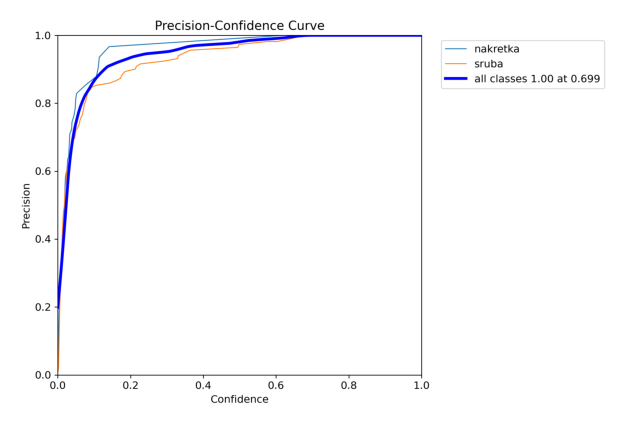

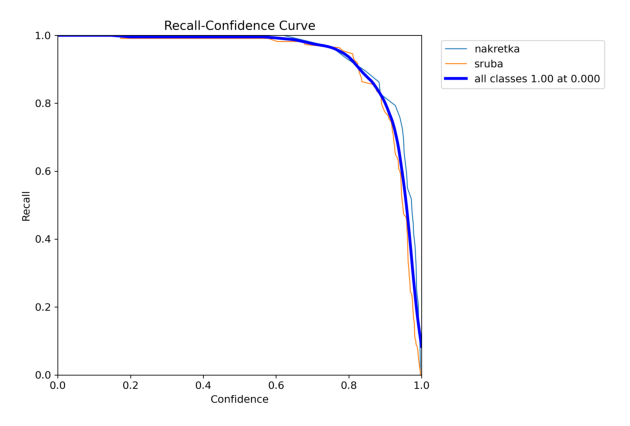

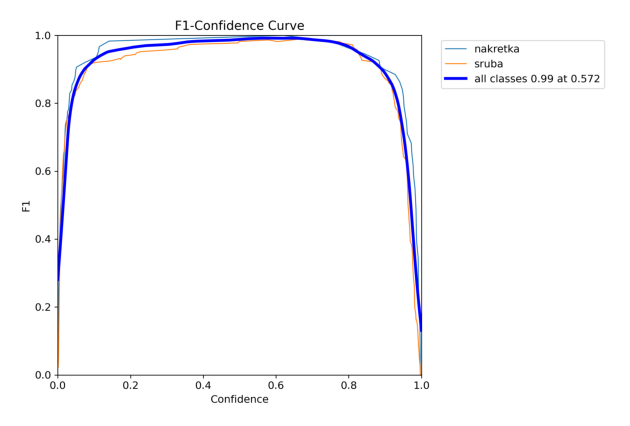

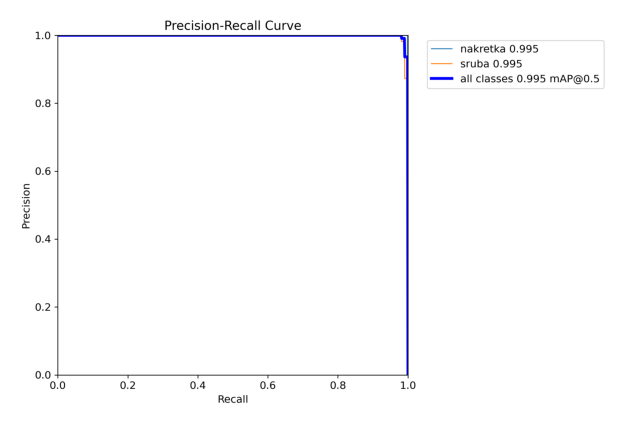

In [38]:
path = "models/Run1NoAUG/"
for name in (
    "P_curve.png",
    "R_curve.png",
    "F1_curve.png",
    "PR_curve.png",
):

    image = cv.imread(path+name)

    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    plt.imshow(image)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

### Augmentacja danych

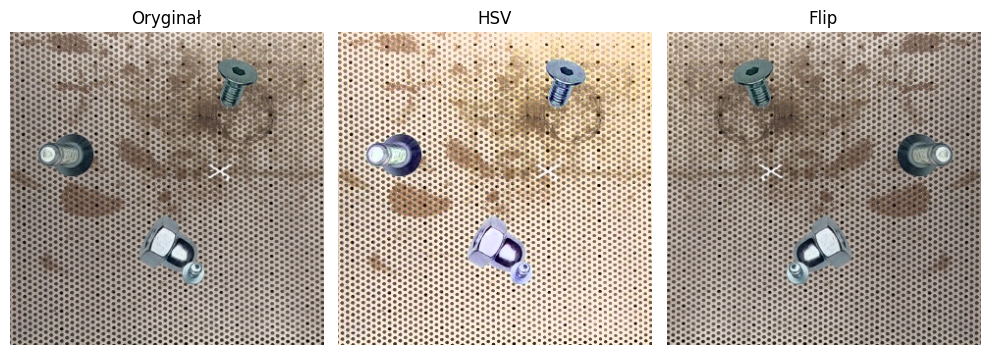

In [39]:
image = cv.imread("Dataset/train/0.jpg")

h,s,v = cv.split(cv.cvtColor(image, cv.COLOR_BGR2HSV))

h = np.mod(h.astype(np.float32)*1.20,180).astype(np.uint8)
s = np.clip(s.astype(np.float32)*1.30,0,255).astype(np.uint8)
v = np.clip(v.astype(np.float32)*1.50,0,255).astype(np.uint8)

image_hsv = cv.merge([h,s,v])

image_flip = cv.flip(image, 1)

image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
image_hsv = cv.cvtColor(image_hsv, cv.COLOR_HSV2RGB)
image_flip = cv.cvtColor(image_flip, cv.COLOR_BGR2RGB)


fig, axes = plt.subplots(1,3, figsize=(10,5))

axes[0].imshow(image)
axes[0].axis('off')
axes[0].set_title("Oryginał")

axes[1].imshow(image_hsv)
axes[1].axis('off')
axes[1].set_title("HSV")

axes[2].imshow(image_flip)
axes[2].axis('off')
axes[2].set_title("Flip")

fig.tight_layout()
fig.show()

### Trening - z augmentacją danych

In [40]:
hiperparametry["epochs"] = 30

hiperparametry["hsv_h"] = 0.015
hiperparametry["hsv_s"] = 0.70
hiperparametry["hsv_v"] =  0.40
hiperparametry["degrees"] = 5.0
hiperparametry["translate"] = 0.15
hiperparametry["scale"] = 0.10
hiperparametry["shear"] = 0.0
hiperparametry["perspective"] = 0.0
hiperparametry["flipud"] = 0.50
hiperparametry["fliplr"] = 0.50
hiperparametry["mosaic"] = 1.0
hiperparametry["close_mosaic"] = 5

In [41]:
model_yolo = YOLO("yolo11n")

kwargs = {
    "data": PATH_TO_DATASET_CONFIG,
    "project": "models",
    "name": "Run2WithAUG",
    "exist_ok": True,
    "plots": True,

}

model_yolo.train(
    **(kwargs | hiperparametry)
)

print("Koniec treningu!")

Ultralytics 8.3.57 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/Dataset/data.yaml, epochs=30, time=None, patience=10, batch=10, imgsz=320, save=True, save_period=-1, cache=False, device=None, workers=8, project=models, name=Run2WithAUG, exist_ok=True, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=5, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_box

train: Scanning /content/Dataset/train.cache... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/Dataset/val.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]

Plotting labels to models/Run2WithAUG/labels.jpg... 


optimizer: Adam(lr=0.0015, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.00046875), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 0 dataloader workers
Logging results to models/Run2WithAUG
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30         0G      1.069      2.434      1.062         34        320: 100%|██████████| 12/12 [00:28<00:00,  2.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.80s/it]

                   all         40        139    0.00375      0.409     0.0823     0.0493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30         0G      1.006      1.708      1.045         40        320: 100%|██████████| 12/12 [00:27<00:00,  2.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.34s/it]

                   all         40        139      0.022      0.289     0.0525     0.0314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30         0G     0.9582      1.445      1.033         47        320: 100%|██████████| 12/12 [00:27<00:00,  2.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.85s/it]

                   all         40        139     0.0125      0.746       0.15      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30         0G     0.9877      1.297      1.027         47        320: 100%|██████████| 12/12 [00:27<00:00,  2.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.87s/it]

                   all         40        139     0.0127      0.991      0.447      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30         0G     0.9783      1.215      1.061         46        320: 100%|██████████| 12/12 [00:28<00:00,  2.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.63s/it]

                   all         40        139      0.987       0.17      0.706      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30         0G     0.9767      1.142      1.034         40        320: 100%|██████████| 12/12 [00:28<00:00,  2.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]

                   all         40        139      0.967      0.384      0.836      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30         0G     0.9381      1.071      1.029         43        320: 100%|██████████| 12/12 [00:28<00:00,  2.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.98s/it]

                   all         40        139      0.931      0.429      0.873      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30         0G     0.9881      1.087      1.062         39        320: 100%|██████████| 12/12 [00:28<00:00,  2.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.59s/it]

                   all         40        139      0.876      0.502      0.904      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30         0G     0.8954      1.001     0.9992         43        320: 100%|██████████| 12/12 [00:27<00:00,  2.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.03s/it]

                   all         40        139      0.802      0.771      0.927      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30         0G     0.9276      1.015      1.008         42        320: 100%|██████████| 12/12 [00:27<00:00,  2.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]

                   all         40        139      0.771      0.741        0.9      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30         0G     0.9139       1.01      1.009         55        320: 100%|██████████| 12/12 [00:27<00:00,  2.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.23s/it]

                   all         40        139       0.84      0.853      0.929        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30         0G     0.9653      0.966      1.025         48        320: 100%|██████████| 12/12 [00:27<00:00,  2.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.28s/it]

                   all         40        139       0.87      0.846       0.95      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30         0G      0.865     0.9116     0.9837         38        320: 100%|██████████| 12/12 [00:28<00:00,  2.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.91s/it]

                   all         40        139      0.882      0.879      0.964      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30         0G     0.8669       0.89      1.004         42        320: 100%|██████████| 12/12 [00:27<00:00,  2.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.91s/it]

                   all         40        139      0.937      0.921      0.973      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30         0G       0.86     0.8759     0.9907         40        320: 100%|██████████| 12/12 [00:27<00:00,  2.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.85s/it]

                   all         40        139      0.949      0.883      0.973      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30         0G     0.8649      0.858     0.9782         53        320: 100%|██████████| 12/12 [00:26<00:00,  2.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.01s/it]

                   all         40        139       0.94      0.927      0.964      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30         0G     0.8575     0.8496     0.9714         45        320: 100%|██████████| 12/12 [00:27<00:00,  2.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.94s/it]

                   all         40        139      0.972      0.939      0.973      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30         0G     0.8508     0.8448     0.9807         53        320: 100%|██████████| 12/12 [00:27<00:00,  2.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.10s/it]

                   all         40        139      0.926      0.952      0.975      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30         0G     0.8296      0.812      0.981         44        320: 100%|██████████| 12/12 [00:27<00:00,  2.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.46s/it]

                   all         40        139      0.917      0.947      0.973       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30         0G     0.8233     0.8047     0.9708         47        320: 100%|██████████| 12/12 [00:28<00:00,  2.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.89s/it]

                   all         40        139      0.909      0.946      0.977      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30         0G     0.7973     0.7736     0.9647         55        320: 100%|██████████| 12/12 [00:27<00:00,  2.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.86s/it]

                   all         40        139      0.912       0.97      0.985      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30         0G     0.8068     0.7777     0.9812         49        320: 100%|██████████| 12/12 [00:28<00:00,  2.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.58s/it]

                   all         40        139      0.942      0.951      0.984      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30         0G     0.7844      0.774     0.9743         43        320: 100%|██████████| 12/12 [00:27<00:00,  2.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]

                   all         40        139      0.948      0.976       0.99      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30         0G     0.7674     0.7578     0.9534         41        320: 100%|██████████| 12/12 [00:27<00:00,  2.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.03s/it]

                   all         40        139      0.969       0.97      0.991       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30         0G     0.7066     0.6969     0.9351         49        320: 100%|██████████| 12/12 [00:28<00:00,  2.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.53s/it]

                   all         40        139      0.967      0.968      0.986      0.807


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30         0G     0.6472     0.6845     0.9043         33        320: 100%|██████████| 12/12 [00:27<00:00,  2.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.06s/it]

                   all         40        139      0.968      0.969      0.984      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30         0G     0.6359     0.6337     0.8933         41        320: 100%|██████████| 12/12 [00:27<00:00,  2.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.87s/it]

                   all         40        139      0.966      0.968      0.984      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30         0G     0.6305     0.6281     0.8867         35        320: 100%|██████████| 12/12 [00:27<00:00,  2.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.87s/it]

                   all         40        139      0.971      0.969      0.983      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30         0G     0.6142     0.6177     0.8898         31        320: 100%|██████████| 12/12 [00:27<00:00,  2.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.70s/it]

                   all         40        139      0.968      0.969      0.983      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30         0G     0.6163     0.6253     0.8879         35        320: 100%|██████████| 12/12 [00:27<00:00,  2.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]

                   all         40        139      0.968      0.969      0.983      0.819



30 epochs completed in 0.279 hours.
Optimizer stripped from models/Run2WithAUG/weights/last.pt, 5.4MB
Optimizer stripped from models/Run2WithAUG/weights/best.pt, 5.4MB

Validating models/Run2WithAUG/weights/best.pt...
Ultralytics 8.3.57 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLO11n summary (fused): 238 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.78s/it]


                   all         40        139      0.968      0.969      0.984      0.827
              nakretka         23         29      0.964      0.966       0.99      0.867
                 sruba         40        110      0.973      0.973      0.979      0.787
Speed: 1.2ms preprocess, 77.2ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to models/Run2WithAUG
Koniec treningu!


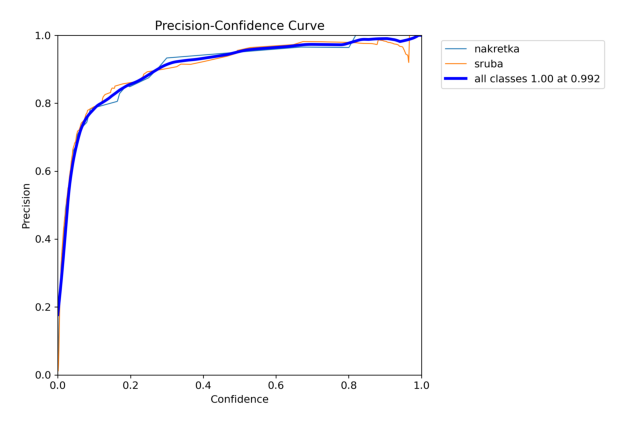

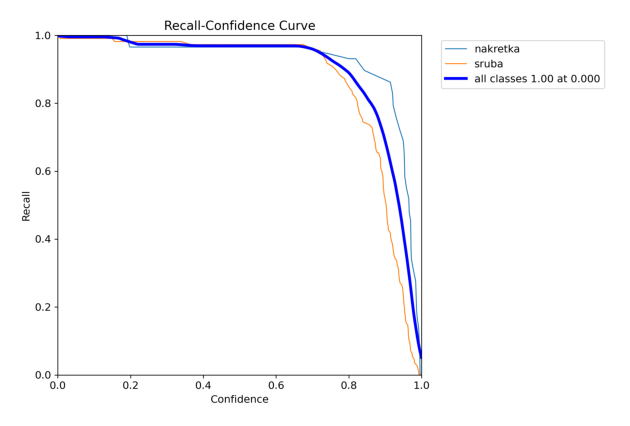

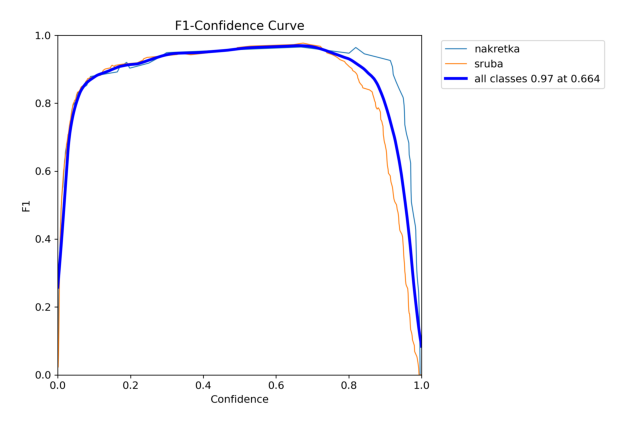

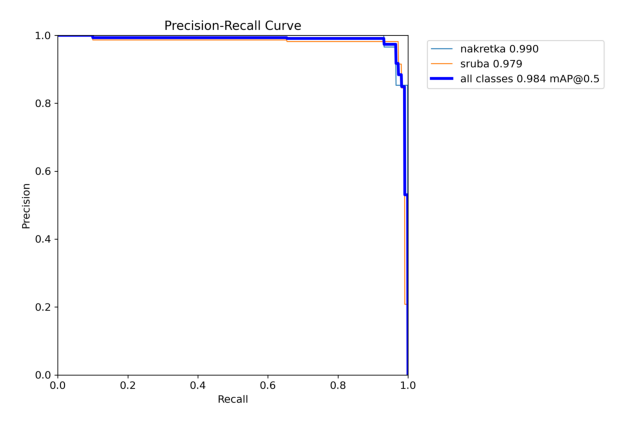

In [46]:
path = "models/Run2WithAUG/"
for name in (
    "P_curve.png",
    "R_curve.png",
    "F1_curve.png",
    "PR_curve.png",
):

    image = cv.imread(path+name)

    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    plt.imshow(image)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

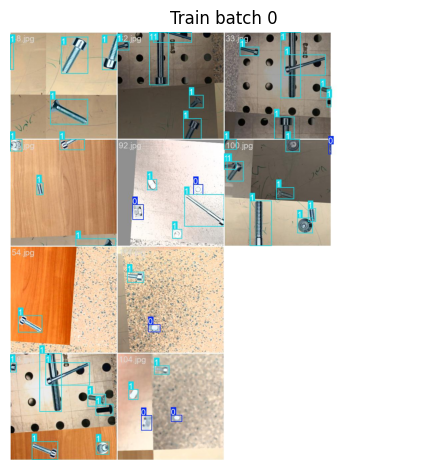

In [44]:
path = "models/Run2WithAUG/train_batch0.jpg"

image = cv.imread(path)

image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

plt.imshow(image)
plt.axis('off')
plt.title("Train batch 0")

plt.tight_layout()
plt.show()

### Walidacja

In [42]:
model_yolo = YOLO("models/Run2WithAUG/weights/best.pt")

metrics_2_val = model_yolo.val(conf=.25, data=PATH_TO_DATASET_CONFIG, split='val', project="models", name="Run2WithAUG_val", exist_ok=True)

Ultralytics 8.3.57 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLO11n summary (fused): 238 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /content/Dataset/val.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]


                   all         40        139      0.968      0.969      0.978      0.843
              nakretka         23         29      0.964      0.966       0.98      0.874
                 sruba         40        110      0.973      0.973      0.976      0.811
Speed: 1.7ms preprocess, 89.2ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to models/Run2WithAUG_val


In [43]:
metrics_2_test = model_yolo.val(conf=.25, data=PATH_TO_DATASET_CONFIG, split='test', project="models", name="Run2WithAUG_test", exist_ok=True)

Ultralytics 8.3.57 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)


val: Scanning /content/Dataset/test.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]


                   all         40        133      0.866      0.786      0.878      0.709
              nakretka         21         30      0.867      0.633      0.804      0.645
                 sruba         40        103      0.866      0.938      0.951      0.773
Speed: 1.5ms preprocess, 89.0ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to models/Run2WithAUG_test


### Porównanie treningów

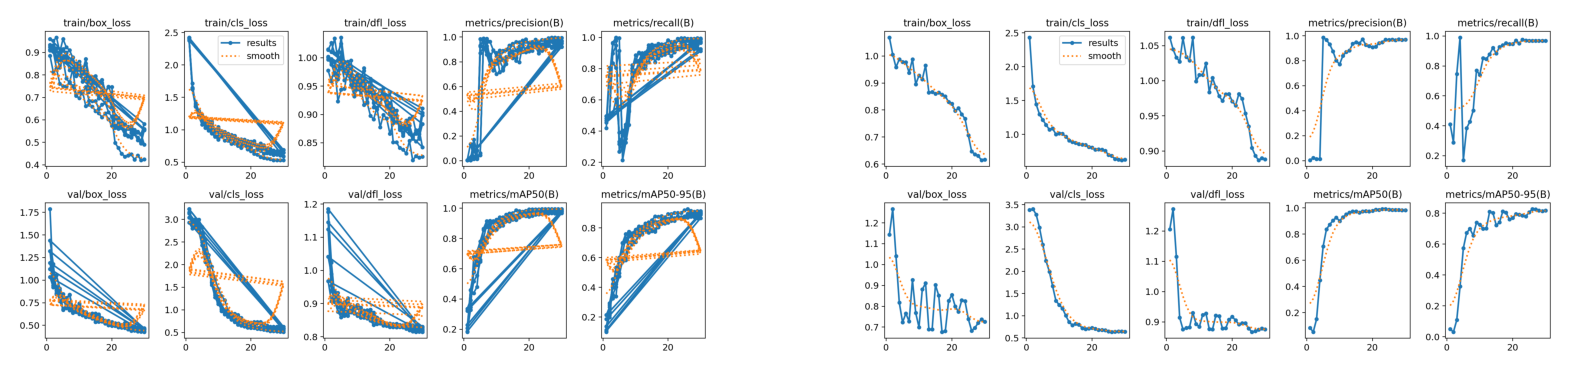

In [47]:
path1 = "models/Run1NoAUG/results.png"
path2 = "models/Run2WithAUG/results.png"

image1 = cv.imread(path1)
image2 = cv.imread(path2)

image1 = cv.cvtColor(image1, cv.COLOR_BGR2RGB)
image2 = cv.cvtColor(image2, cv.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(image1)
axes[0].axis('off')

axes[1].imshow(image2)
axes[1].axis('off')

plt.show()

In [48]:
for metric in ("mAP50", "precision", "recall"):
    print(f"{metric}:")
    print("\t       Val    Test")
    print(f"\tRun 1: {metrics_1_val.results_dict[f'metrics/{metric}(B)']*100.0:.2f}, {metrics_1_test.results_dict[f'metrics/{metric}(B)']*100.0:.2f}")
    print(f"\tRun 2: {metrics_2_val.results_dict[f'metrics/{metric}(B)']*100.0:.2f}, {metrics_2_test.results_dict[f'metrics/{metric}(B)']*100.0:.2f}")

mAP50:
	       Val    Test
	Run 1: 99.49, 93.24
	Run 2: 97.76, 87.75
precision:
	       Val    Test
	Run 1: 99.09, 93.69
	Run 2: 96.82, 86.62
recall:
	       Val    Test
	Run 1: 99.55, 88.59
	Run 2: 96.91, 78.57
